In [1]:
import rebound
import numpy as np
from scipy.interpolate import interp2d, interp1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy import time
import pandas as pd


%matplotlib notebook

In [2]:
import seaborn as sns


# For dark background plots 
sns.set(font_scale=10)

sns.set(font='Arial',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'black',
 'axes.grid': False,
 'axes.labelcolor': 'white',
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'black',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'white',
 'xtick.bottom': True,
 'xtick.color': 'white',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'white',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False,
 'figure.dpi':100, 
 'savefig.dpi':100})
sns.set_context("notebook", rc={"font.size":18,
                                "axes.titlesize":18,
                                "axes.labelsize":18})
sns.set_palette("colorblind", color_codes=True)




In [3]:
import seaborn as sns

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})

sns.set(font='Arial',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'black',
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': True,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":16,
                                "axes.labelsize":16})
sns.set_palette("colorblind", color_codes=True)


In [4]:
# Binary parameters (Zuniga-Fernandez et al. 2021)

t_ref = time.Time(2023, format='decimalyear').mjd   # t_ref = T0_AB 

# fA_i = 0.87 + 0.13                     # incident flux
# fAa_i = 0.87
# fAb_i = 0.13
# flux_ratio_B = 70
# flux_ratio_A = 15
fr = 3.9
f_A = 1580
fAa_i = (f_A*fr)/(1+fr)
fAb_i = f_A - fAa_i

e_B = 0.805
i_B = -np.radians(66.3)
a_B = 1.01
m_Ba = 0.77
m_Bb = 0.62
omega_Ba = np.radians(104.5)
omega_Bb = omega_Ba - np.pi
Omega_B = np.radians(342.7)+np.pi/2
T0_B = 48707.5
P_B = 314.86
mean_B = (2*np.pi*((t_ref - T0_B)/P_B))%(2*np.pi)

e_A = 0.4808
i_A = -np.radians(135.6)
a_A = 0.86
m_Aa = 0.93
m_Ab = 0.29
omega_Aa = np.radians(68.7)
omega_Ab = omega_Aa - np.pi
Omega_A = np.radians(170.2)+np.pi/2
T0_A = 48742.5
P_A = 264.51
mean_A = (2*np.pi*((t_ref - T0_A)/P_A))%(2*np.pi)

e_AB = 0.46
i_AB = -np.radians(88.1)
a_AB = 51
m_A = 1.22
m_B = 1.4
omega_A = np.radians(65)
omega_B = omega_A - np.pi
Omega_AB = np.radians(184.5)+np.pi/2
T0_AB = 2023
P_AB = 230
mean_AB = 0.0


# Disc parameters (Kennedy et al. 2019)
a_inner = 2.5
a_outer = 4.6
e_disc = 0.03
pos_disc = np.radians(15.6) + np.pi/2
inc_disc = np.radians(26)
omega_disc = np.radians(-73)
b_inner = a_inner*np.cos(inc_disc)*(1-e_disc**2)**0.5
b_outer = a_outer*np.cos(inc_disc)*(1-e_disc**2)**0.5




In [5]:
def convmf(m_in, e_in):
    """Convert array of mean to true anomaly (for single e).
        
    From Vallado
    
    .. todo: tidy and include other orbit cases
    """
    
    m = np.array(m_in % (2. * np.pi))
    numiter = 50
    small = 0.00000001
    if e_in > small:
        
        ecc = np.array(e_in * 1.0)
        
        #       ;; /* ------------  initial guess ------------- */
        e0 = np.array(m + ecc)
        lo = np.logical_or( (m < 0.0) & (m > -np.pi), m > np.pi)
        e0[lo] = m[lo] - ecc
        
        ktr = 1
        e1  = np.array(e0 + (m - e0 + ecc * np.sin(e0)) / (1.0 - ecc * np.cos(e0)))
        while (np.max(np.abs(e1 - e0)) > small) & (ktr <= numiter):
            ktr += 1
            do = np.abs(e1 - e0) > small
            e0[do] = e1[do]
            e1[do] = e0[do] + (m[do] - e0[do] + ecc * np.sin(e0[do])) / (1.0 - ecc * np.cos(e0[do]))
        
        #       ;; /* ---------  find true anomaly  ----------- */
        sinv = (np.sqrt(1.0 - ecc * ecc) * np.sin(e1)) / (1.0-ecc * np.cos(e1))
        cosv = (np.cos(e1) - ecc) / (1.0 - ecc * np.cos(e1))
        nu   = np.arctan2( sinv, cosv)
    
    else:
        #       ;; /* --------------------- circular --------------------- */
        ktr = 0
        nu  = m
        e0  = m

    if ktr > numiter:
        print('WARNING: convmf did not converge')
    
    return nu

anom_A = convmf(mean_A, e_A)
anom_B = convmf(mean_B, e_B)
anom_AB  = convmf(mean_AB, e_AB)


In [6]:
print(np.degrees(anom_A))
print(np.degrees(anom_B))
print(np.degrees(anom_AB))

157.706322184098
-166.60030265538973
2.903104364469517e-31


In [7]:
# Build disc

angles = np.linspace(0, 2*np.pi, 100)

x_outer = a_outer*np.cos(angles)
y_outer = b_outer*np.sin(angles)
z_outer = x_outer*np.tan(inc_disc)

x_inner = a_inner*np.cos(angles)
y_inner = b_inner*np.sin(angles)
z_inner = x_inner*np.tan(inc_disc)

# Rotate disc
x_o = x_outer*np.cos(pos_disc) - y_outer*np.sin(pos_disc)
y_o = x_outer*np.sin(pos_disc) + y_outer*np.cos(pos_disc)
x_i = x_inner*np.cos(pos_disc) - y_inner*np.sin(pos_disc)
y_i = x_inner*np.sin(pos_disc) + y_inner*np.cos(pos_disc)

x_inner = x_i
y_inner = y_i
x_outer = x_o
y_outer = y_o

In [8]:
# Create 3 star system - B + Aa + Ab

# Create system B (Ba + Bb)

sim = rebound.Simulation()
sim.units = ('days', 'AU', 'Msun')

B = rebound.Particle(simulation=sim,
                      m=m_B,
                     )



sim.add(B)

# Create AaAb as a single object representing the CoM of AaAb relative to the CoM of BaBb

A = rebound.Particle(simulation=sim,
                     primary=B,
                     m=m_A,
                     a=a_AB,
                     e=e_AB,
                     omega=omega_A,
                     inc=i_AB,
                     Omega=Omega_AB,
                     M=mean_AB
                    )

# Create system AaAb and shift to CoM reference frame

sim_A = rebound.Simulation()
sim_A.units = ('days', 'AU', 'Msun')
sim_A.move_to_hel()



Aa = rebound.Particle(simulation=sim_A,
                      m=m_Aa,
                     )

Ab = rebound.Particle(simulation=sim_A,
                      primary=Aa,
                      m=m_Ab,
                      a=a_A,
                      e=e_A,
                      omega=omega_Ab,
                      inc=i_A,
                      Omega=Omega_A,
                      M=mean_A
                     )


sim_A.add(Aa)
sim_A.add(Ab)
sim_A.move_to_com()
Aa_A, Ab_A = sim_A.particles      # Aa and Ab in the A CoM reference frame


# Shift Aa and Ab into the system B CoM reference frame

def change_reference_frames(star, ref):
    # ref = old reference frame in the new reference frame
    # star = star in the old reference frame
    ref_v = np.array([ref.vx, ref.vy, ref.vz])                            # velocity of current reference frame in the new reference frame
    v_in_ref = np.array([star.vx, star.vy, star.vz])                      # velocity of star in current reference frame
    v = v_in_ref + ref_v                                                  # velocity of star in the new reference frame
    
    ref_pos = np.array([ref.x, ref.y, ref.z])                             # position of current reference frame in the new reference frame
    pos_in_ref = np.array([star.x, star.y, star.z])                       # position of star in current reference frame
    pos = pos_in_ref + ref_pos                                            # position of star in the new reference frame
    
    return pos,v

pos_Aa, v_Aa = change_reference_frames(Aa_A, A)
pos_Ab, v_Ab = change_reference_frames(Ab_A, A)

def generate_cartesian_particle(m, pos, v):
    x, y, z = pos
    vx, vy, vz = v
    return rebound.Particle(m=m, x=x, y=y, z=z, vx=vx, vy=vy, vz=vz)

Aa = generate_cartesian_particle(m_Aa, pos_Aa, v_Aa)
Ab = generate_cartesian_particle(m_Ab, pos_Ab, v_Ab)

sim.add(Aa)
sim.add(Ab)
sim.move_to_com()



In [9]:
# Plot orbits

start_time = 0
t_max = 18*365.25 + start_time   # integrate over 18 years
n_steps = int(1e4)
times = np.linspace(start_time, t_max, n_steps)

# Initialise arrays for the orbital parameters of the four stars

x_B, y_B, z_B = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)  
x_Aa, y_Aa, z_Aa = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
x_Ab, y_Ab, z_Ab = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)

vx_B, vy_B, vz_B= np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Aa, vy_Aa, vz_Aa = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Ab, vy_Ab, vz_Ab = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)

B, Aa, Ab = sim.particles

xa_transits = []
ya_transits = []

xb_transits = []
yb_transits = []

flux_Aa = np.zeros(n_steps)
flux_Ab = np.zeros(n_steps)

for i, t in enumerate(times):
    sim.integrate(t)

    pos_B = np.array([B.x, B.y, B.z])
    v_B = np.array([B.vx, B.vy, B.vz])
    
    # Recenter all components so the B is at the origin
    x_Aa[i], y_Aa[i], z_Aa[i] = np.array([Aa.x, Aa.y, Aa.z]) - pos_B
    x_Ab[i], y_Ab[i], z_Ab[i] = np.array([Ab.x, Ab.y, Ab.z]) - pos_B
    vx_Aa[i], vy_Aa[i], vz_Aa[i] = np.array([Aa.vx, Aa.vy, Aa.vz]) - v_B
    vx_Ab[i], vy_Ab[i], vz_Ab[i] = np.array([Ab.vx, Ab.vy, Ab.vz]) - v_B
    
    x_B[i], y_B[i], z_B[i] = np.array([B.x, B.y, B.z]) - pos_B
    vx_B[i], vy_B[i], vz_B[i] = np.array([B.vx, B.vy, B.vz]) - v_B
    
    # Rotate disc and A to y=0 to determine when transit is happening     
    x_a, y_a = x_Aa[i], y_Aa[i]
    r_a = (x_a**2 + y_a**2)**0.5      # x_a=r, y_a=0 after rotation
    theta_a = np.arctan2(y_a,x_a)

    x_b, y_b = x_Ab[i], y_Ab[i]
    r_b = (x_b**2 + y_b**2)**0.5      # x_a=r, y_a=0 after rotation
    theta_b = np.arctan2(y_b,x_b)

    phi_a = pos_disc - theta_a    # effective position angle of disc (in relation to Aa)
    phi_b = pos_disc - theta_b    # effective position angle of disc (in relation to Ab)
    
    F_inner = (a_inner**2)*(b_inner**2)
    F_outer = (a_outer**2)*(b_outer**2)
    Aa_inner =  (a_inner**2)*(np.sin(phi_a)**2) + (b_inner**2)*(np.cos(phi_a)**2)
    Aa_outer =  (a_outer**2)*(np.sin(phi_a)**2) + (b_outer**2)*(np.cos(phi_a)**2)
    Ab_inner =  (a_inner**2)*(np.sin(phi_b)**2) + (b_inner**2)*(np.cos(phi_b)**2)
    Ab_outer =  (a_outer**2)*(np.sin(phi_b)**2) + (b_outer**2)*(np.cos(phi_b)**2) 
    
    xa_inner2 =  (F_inner/Aa_inner)**0.5
    xa_outer2 = (F_outer/Aa_outer)**0.5
    xb_inner2 =  (F_inner/Ab_inner)**0.5
    xb_outer2 = (F_outer/Ab_outer)**0.5
    
    # Calculate distance to particle in disc plane
    yp_a = r_a*np.cos(phi_a)/np.cos(inc_disc)
    xp_a = r_a*np.sin(phi_a)
    rp_a = (xp_a**2 + yp_a**2)**0.5

    yp_b = r_b*np.cos(phi_b)/np.cos(inc_disc)  
    xp_b = r_b*np.sin(phi_b)
    rp_b = (xp_b**2 + yp_b**2)**0.5


    r0_a = abs(xa_inner2) 
    r0_b = abs(xb_inner2)
    
    tau_disc_a = 0.5*r0_a/rp_a
    tau_disc_b = 0.5*r0_b/rp_b
    
    # Calculating flux during transit
    fAa_t = fAa_i*np.exp(-tau_disc_a)   
    fAb_t = fAb_i*np.exp(-tau_disc_b)   


    if xa_inner2 < r_a < xa_outer2:
        xa_transits.append(x_Aa[i])
        ya_transits.append(y_Aa[i])
        flux_Aa[i] = fAa_t
    else:
        flux_Aa[i] = fAa_i

    if xb_inner2 < r_b < xb_outer2:
        xb_transits.append(x_Ab[i])
        yb_transits.append(y_Ab[i])
        flux_Ab[i] = fAb_t
    else:
        flux_Ab[i] = fAb_i

print(len(xa_transits))
print(len(xb_transits))


943
1160


<IPython.core.display.Javascript object>


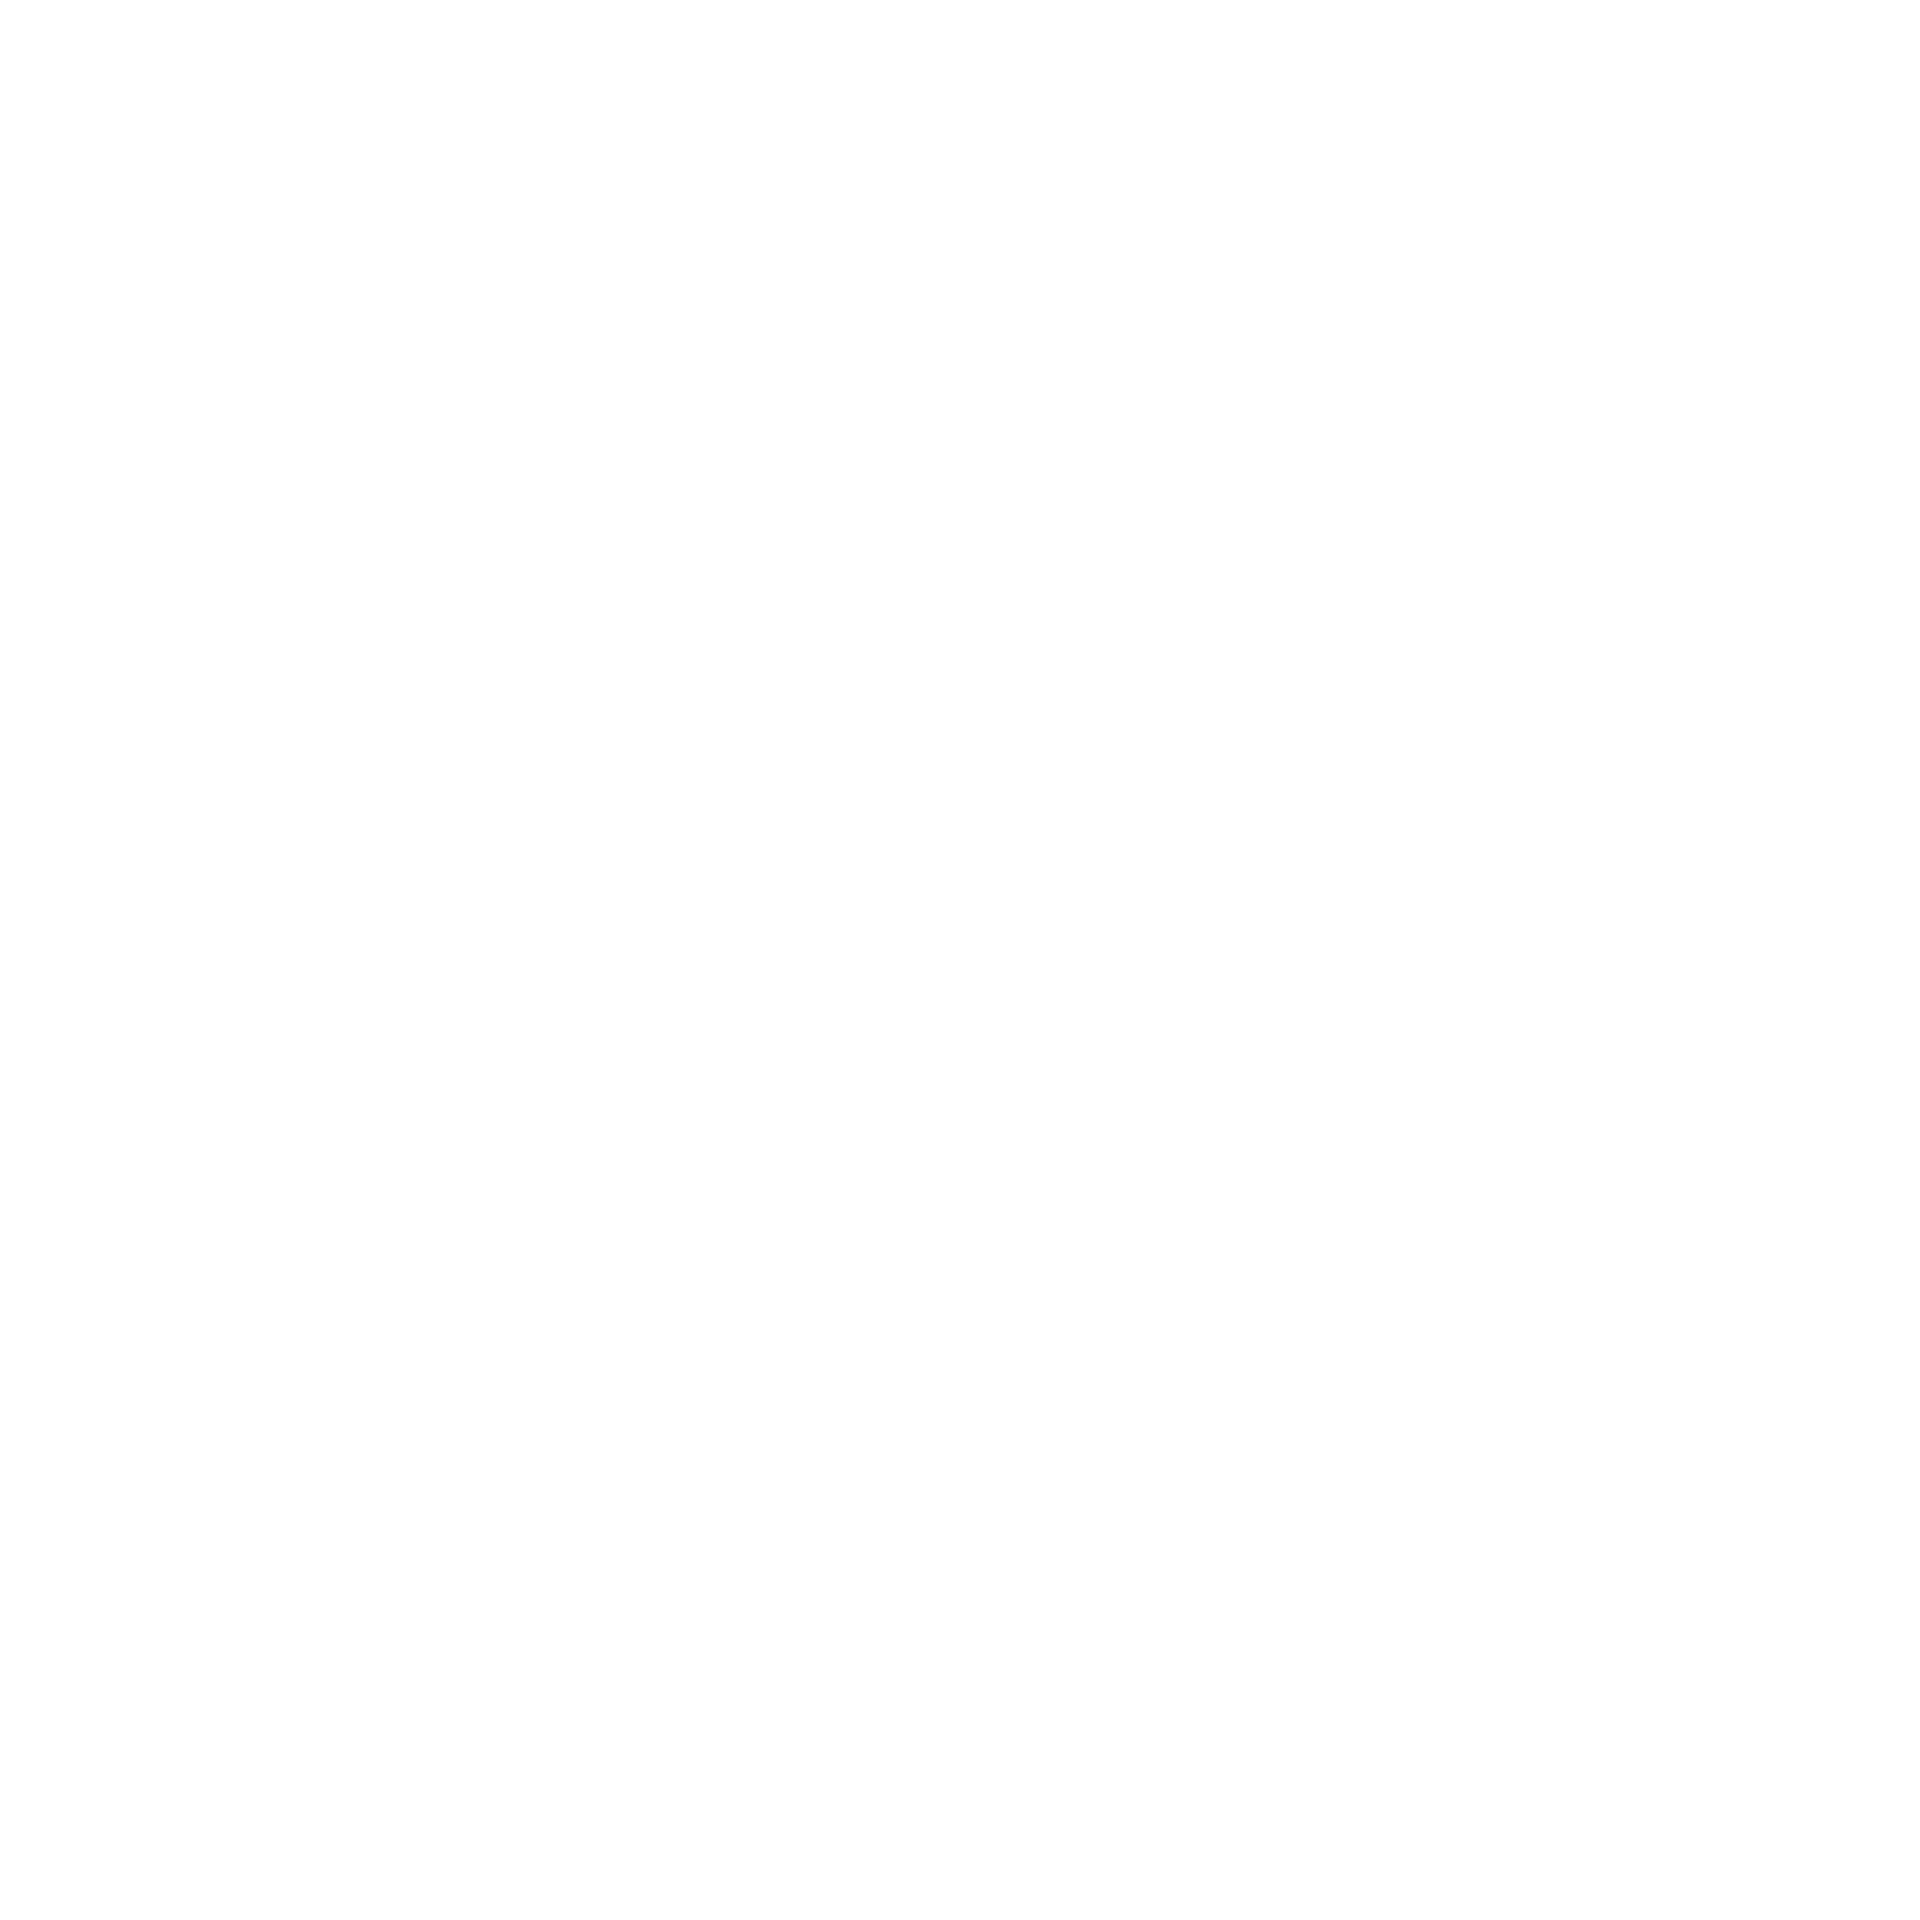

<IPython.core.display.Javascript object>


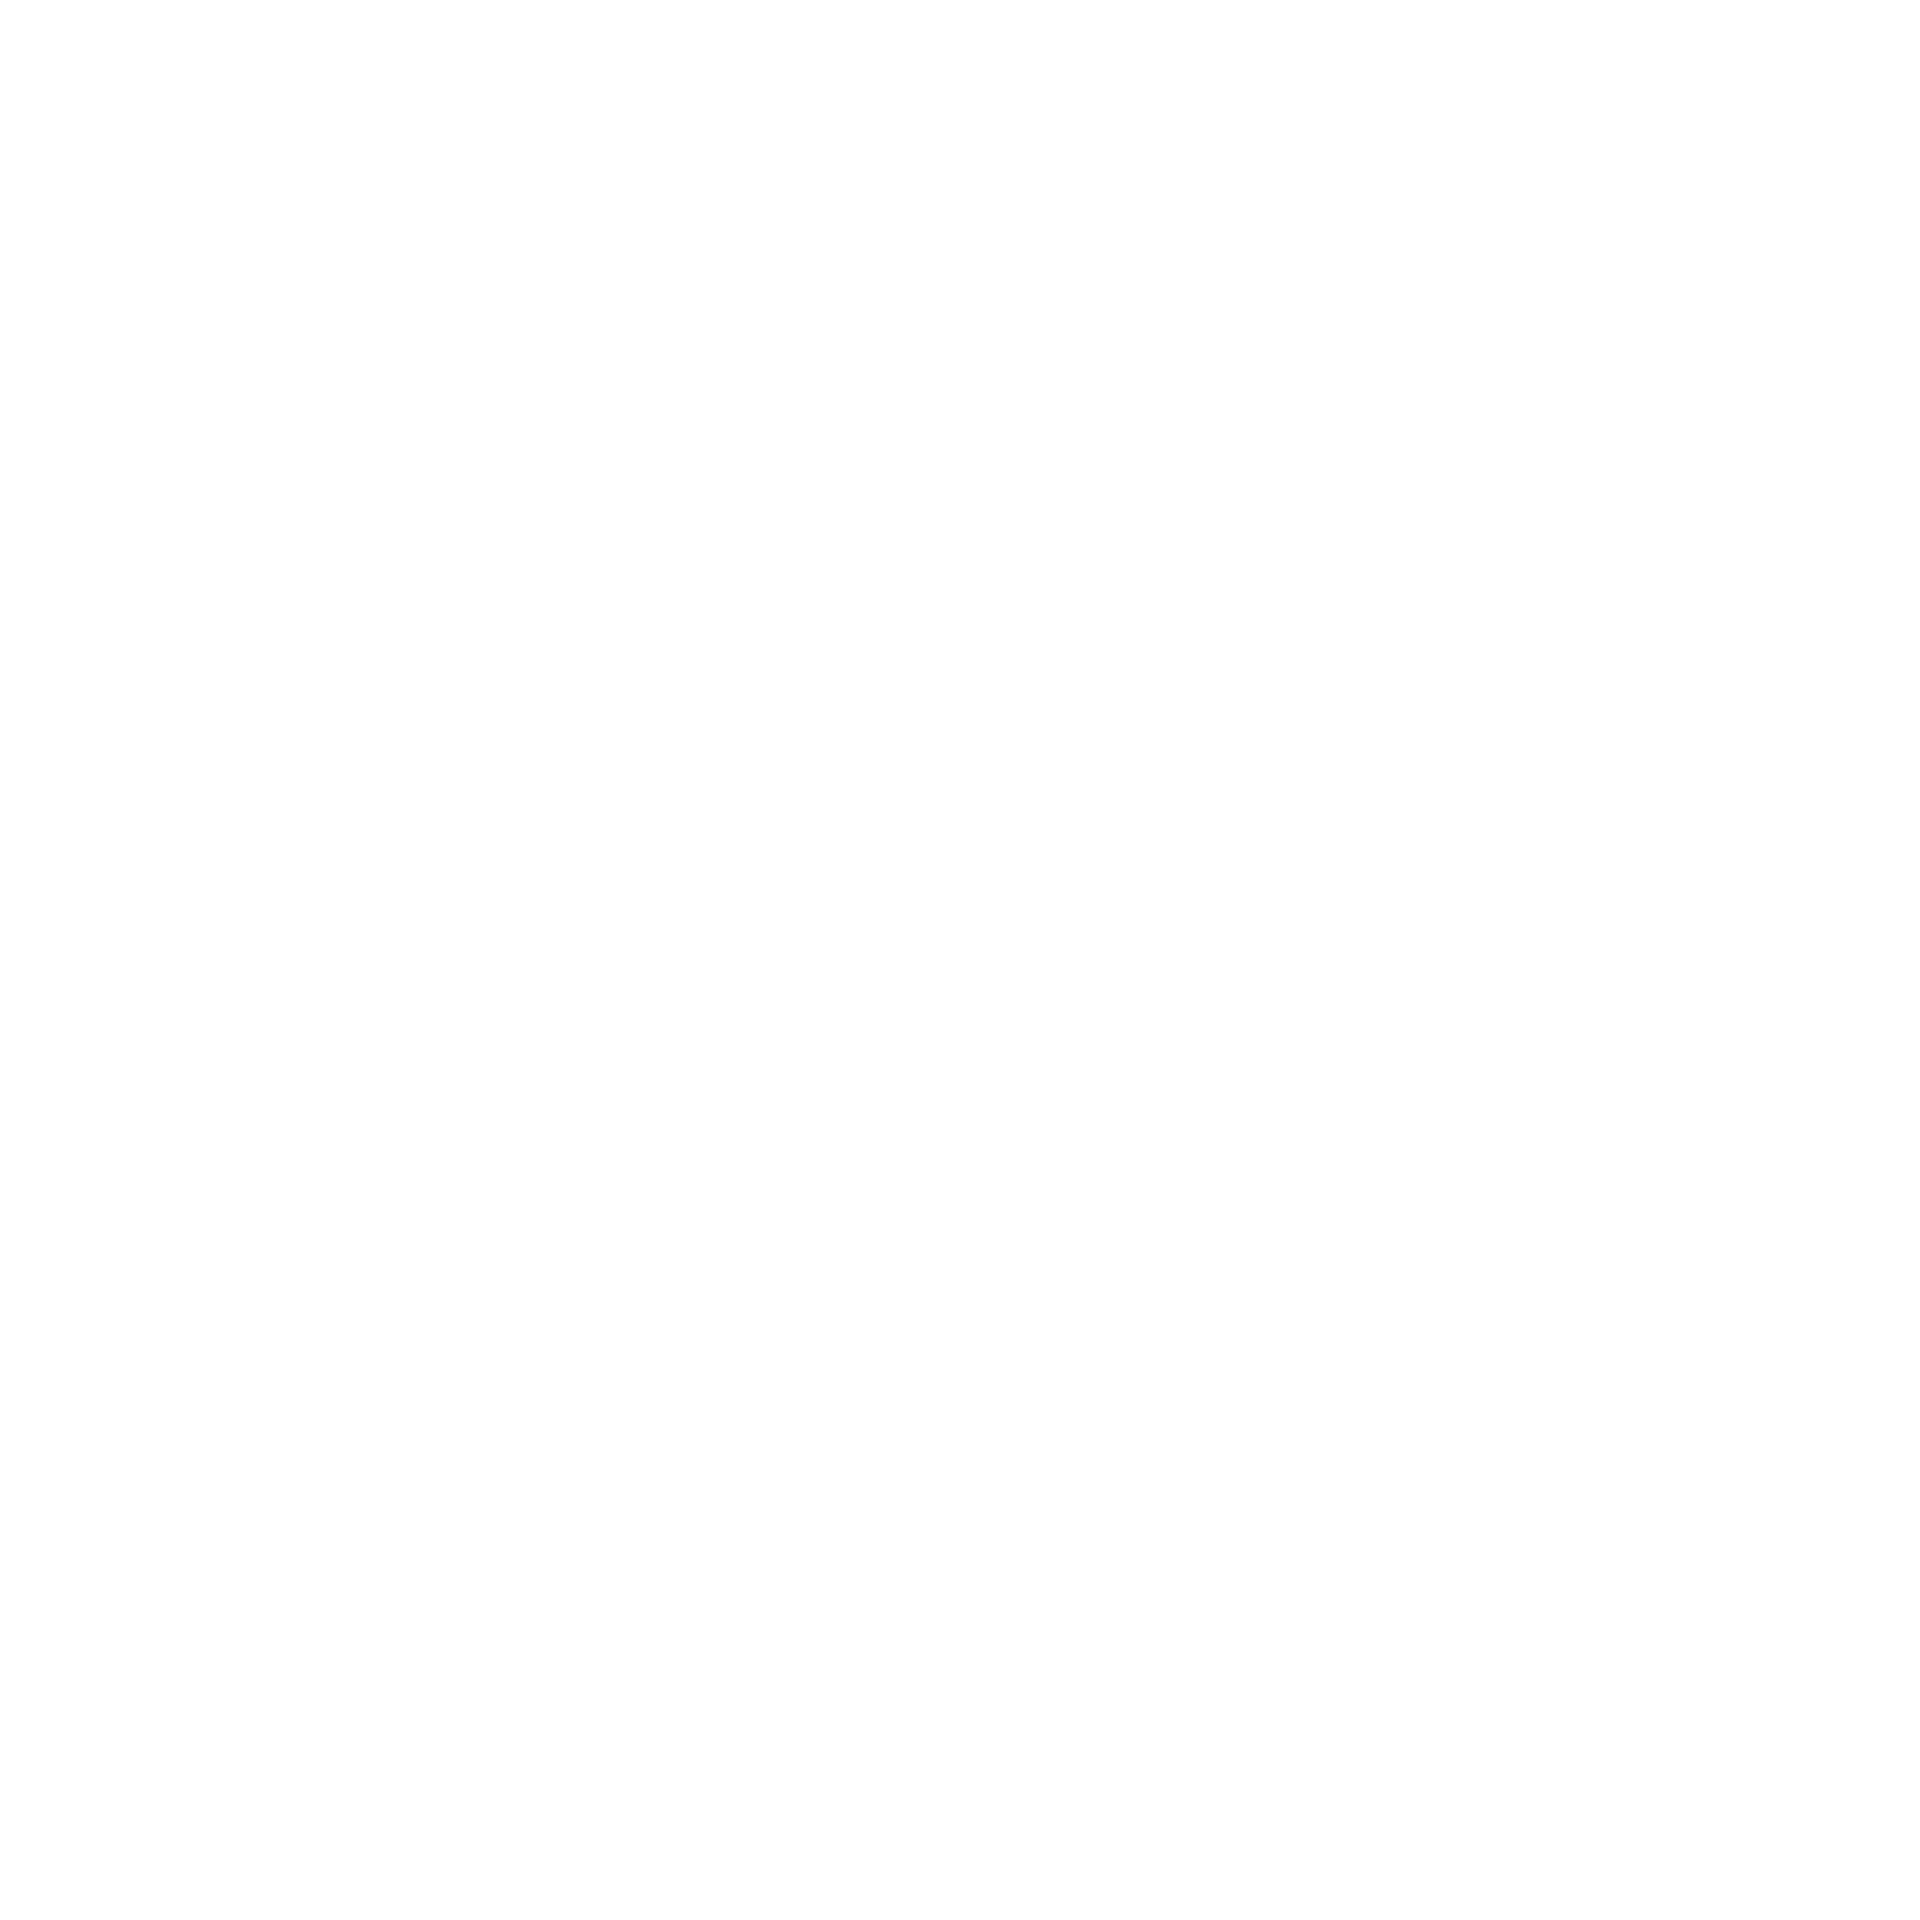

In [32]:
# Make 2D plot
fig1 = plt.figure(1, figsize=(8,8))

plt.plot(x_B, y_B, 'r.', alpha = 0.5, markersize=10, label='B', figure=fig1)
plt.plot(x_Aa, y_Aa, 'g.', alpha = 0.5, markersize=2, label='Aa', figure=fig1)
plt.plot(x_Ab, y_Ab, 'y.', alpha = 0.5, markersize=2, label='Ab', figure=fig1)

plt.plot(x_inner, y_inner, 'k', alpha=0.3)
plt.plot(x_outer, y_outer, 'k', alpha=0.3)
plt.plot(xa_transits, ya_transits, 'b.', markersize=5, label = 'Transit', figure=fig1)
plt.plot(xb_transits, yb_transits, 'b.', markersize=5, label = 'Transit', figure=fig1)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.legend()

<IPython.core.display.Javascript object>


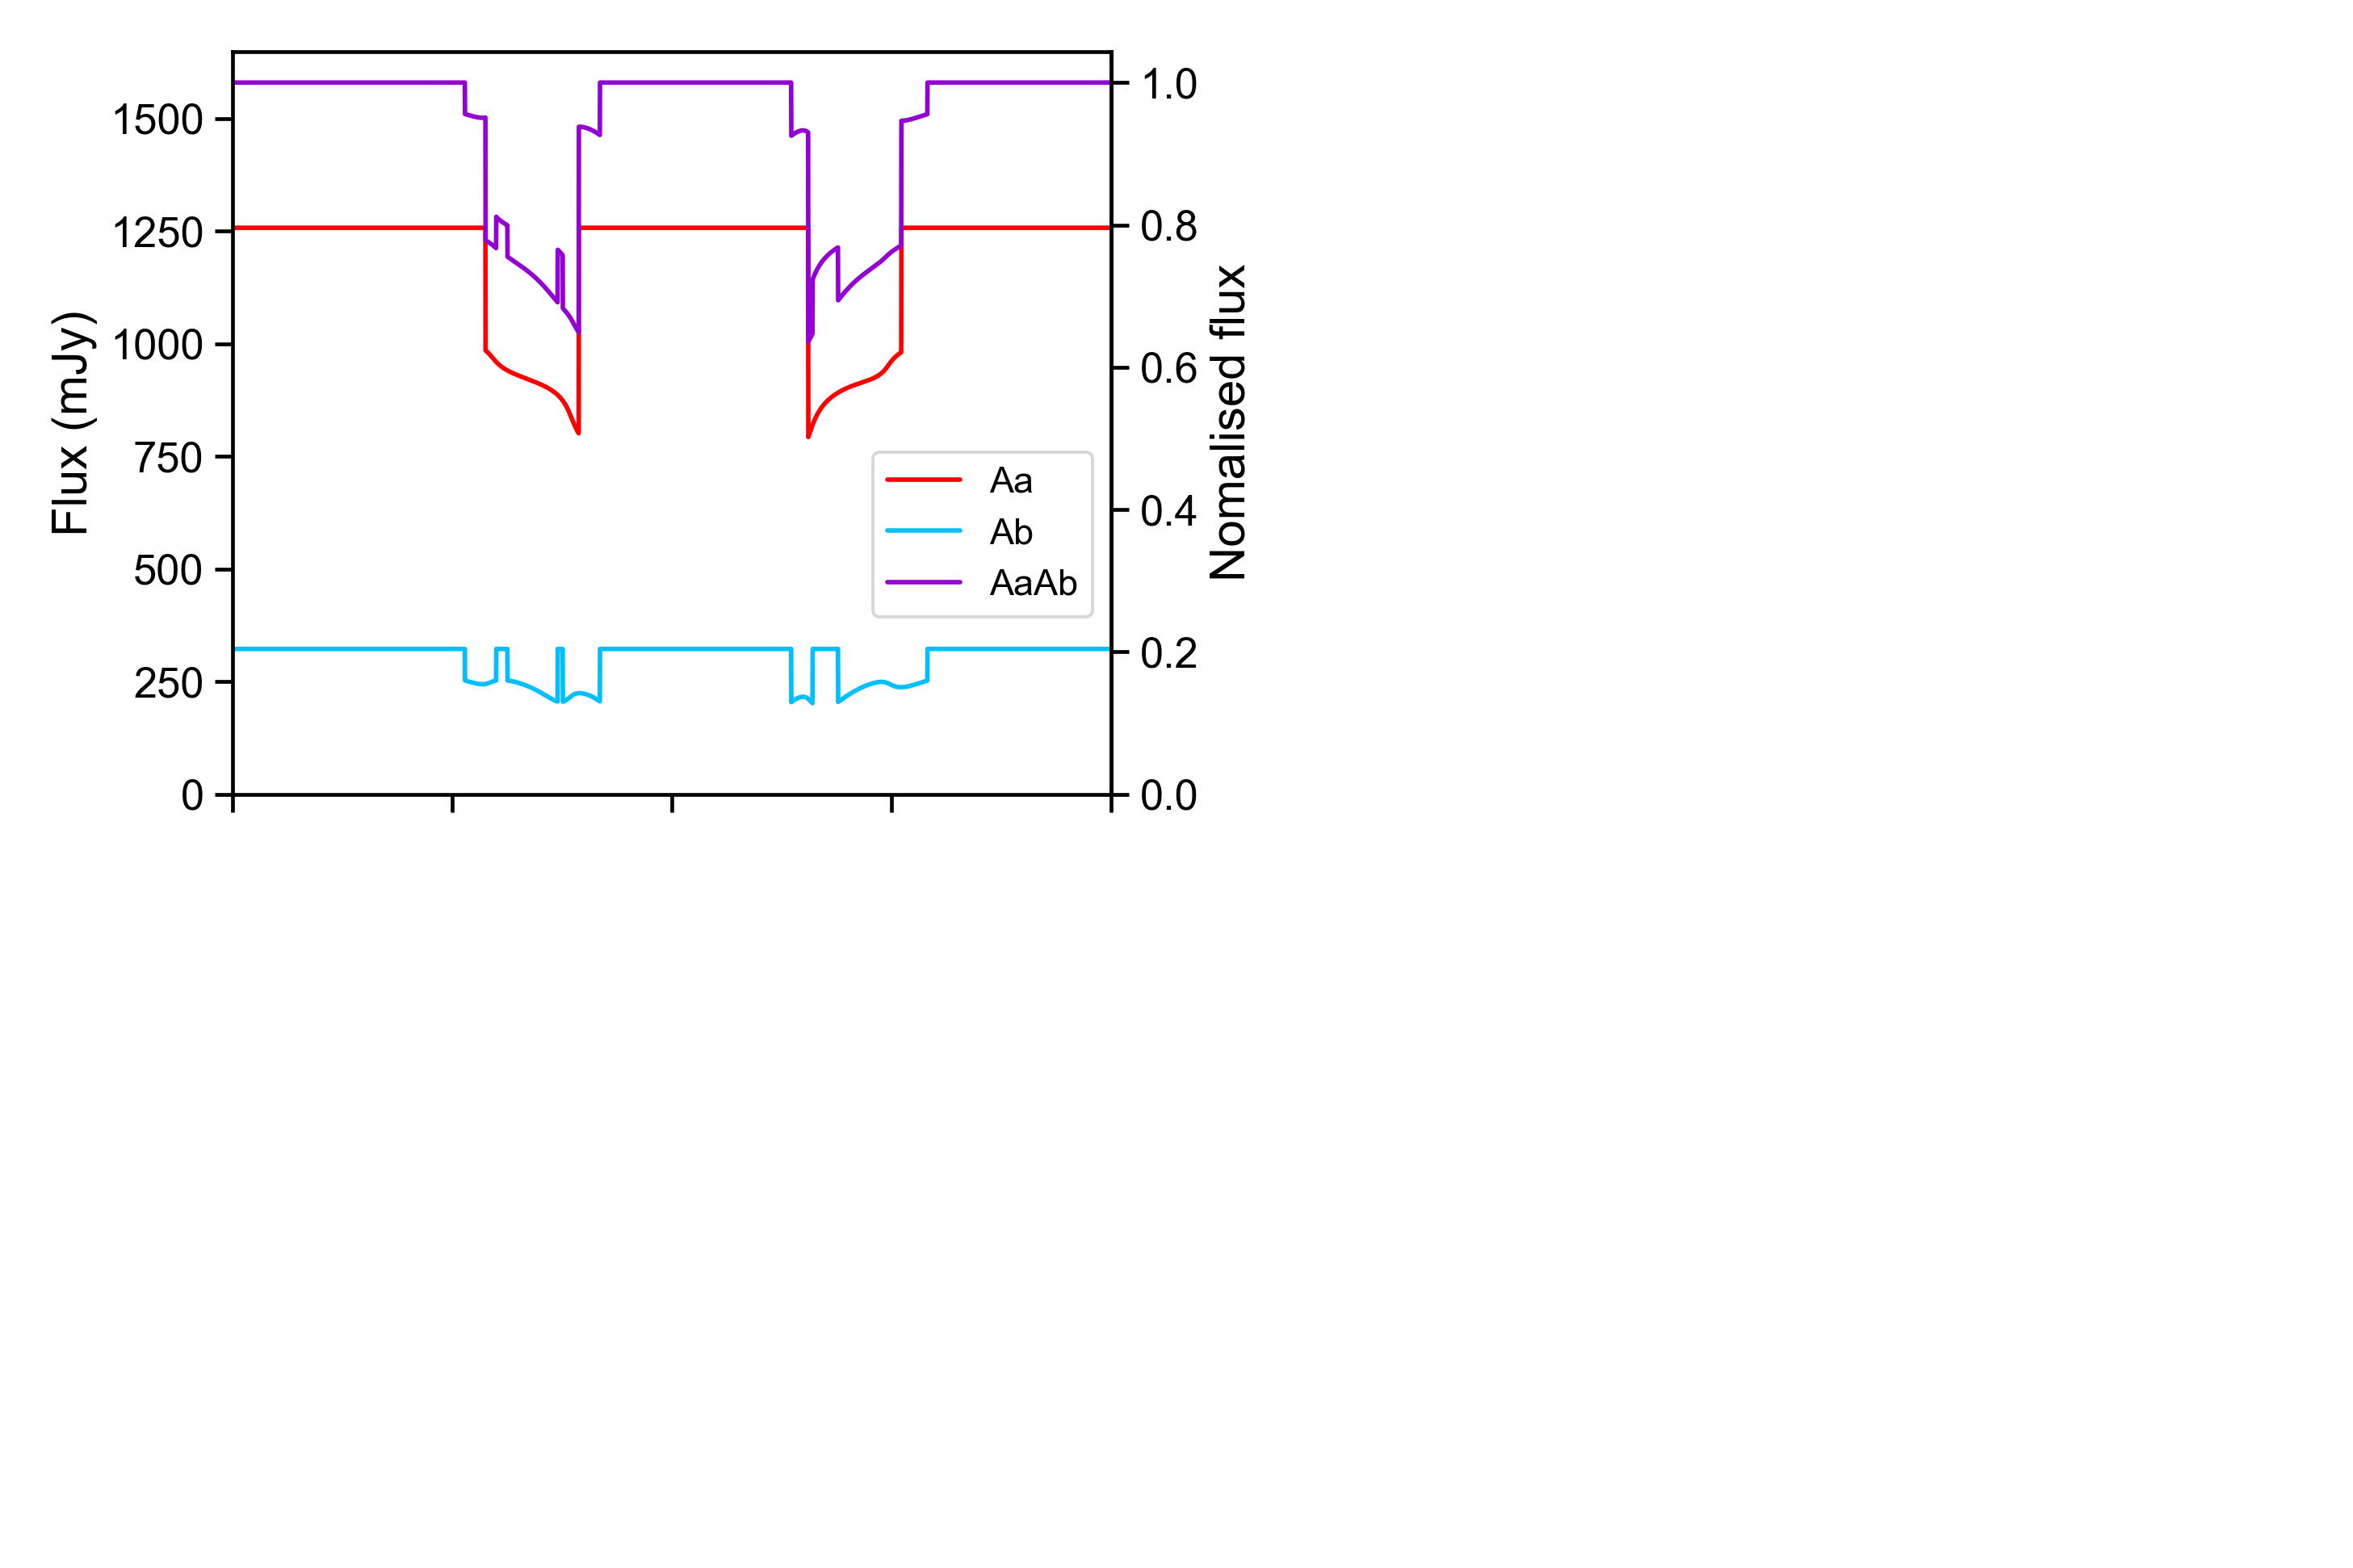

In [55]:
# Plot lightcurve during transit
fig, ax = plt.subplots(figsize=(6,4))
t_yrs = (times/365.25) + 2023
ax.plot(t_yrs, flux_Aa, 'red', label = 'Aa')
ax.plot(t_yrs, flux_Ab,  'deepskyblue', label = 'Ab')
ax.plot(t_yrs, flux_Ab+flux_Aa, 'darkviolet', label = 'AaAb')

# ax.set_xlabel("Year")
ax.set_ylabel("Flux (mJy)")
ax.set_xlim(2024,2032)
ax.set_xticks([2024,2026,2028,2030,2032])
ax.set_ylim(0,)
# fig.tight_layout()

leg = plt.legend(loc='right', bbox_to_anchor=(1, 0.35), prop={'size': 12})
frame = leg.get_frame()
frame.set_facecolor('white')
ax.tick_params(axis='both', which='major', labelsize=14)

f_norm_A = lambda f: f/(fAa_i+fAb_i)
f_denorm_A = lambda f: f*(fAa_i+fAb_i)

plt.setp( ax.get_xticklabels(), visible=False)

secax0 = ax.secondary_yaxis(location='right', functions=(f_norm_A, f_denorm_A))
secax0.tick_params(axis='both', which='major', labelsize=14)
secax0.set_ylabel('Nomalised flux')
fig.tight_layout()

fig.savefig('REBOUND_LC1.png')


<IPython.core.display.Javascript object>


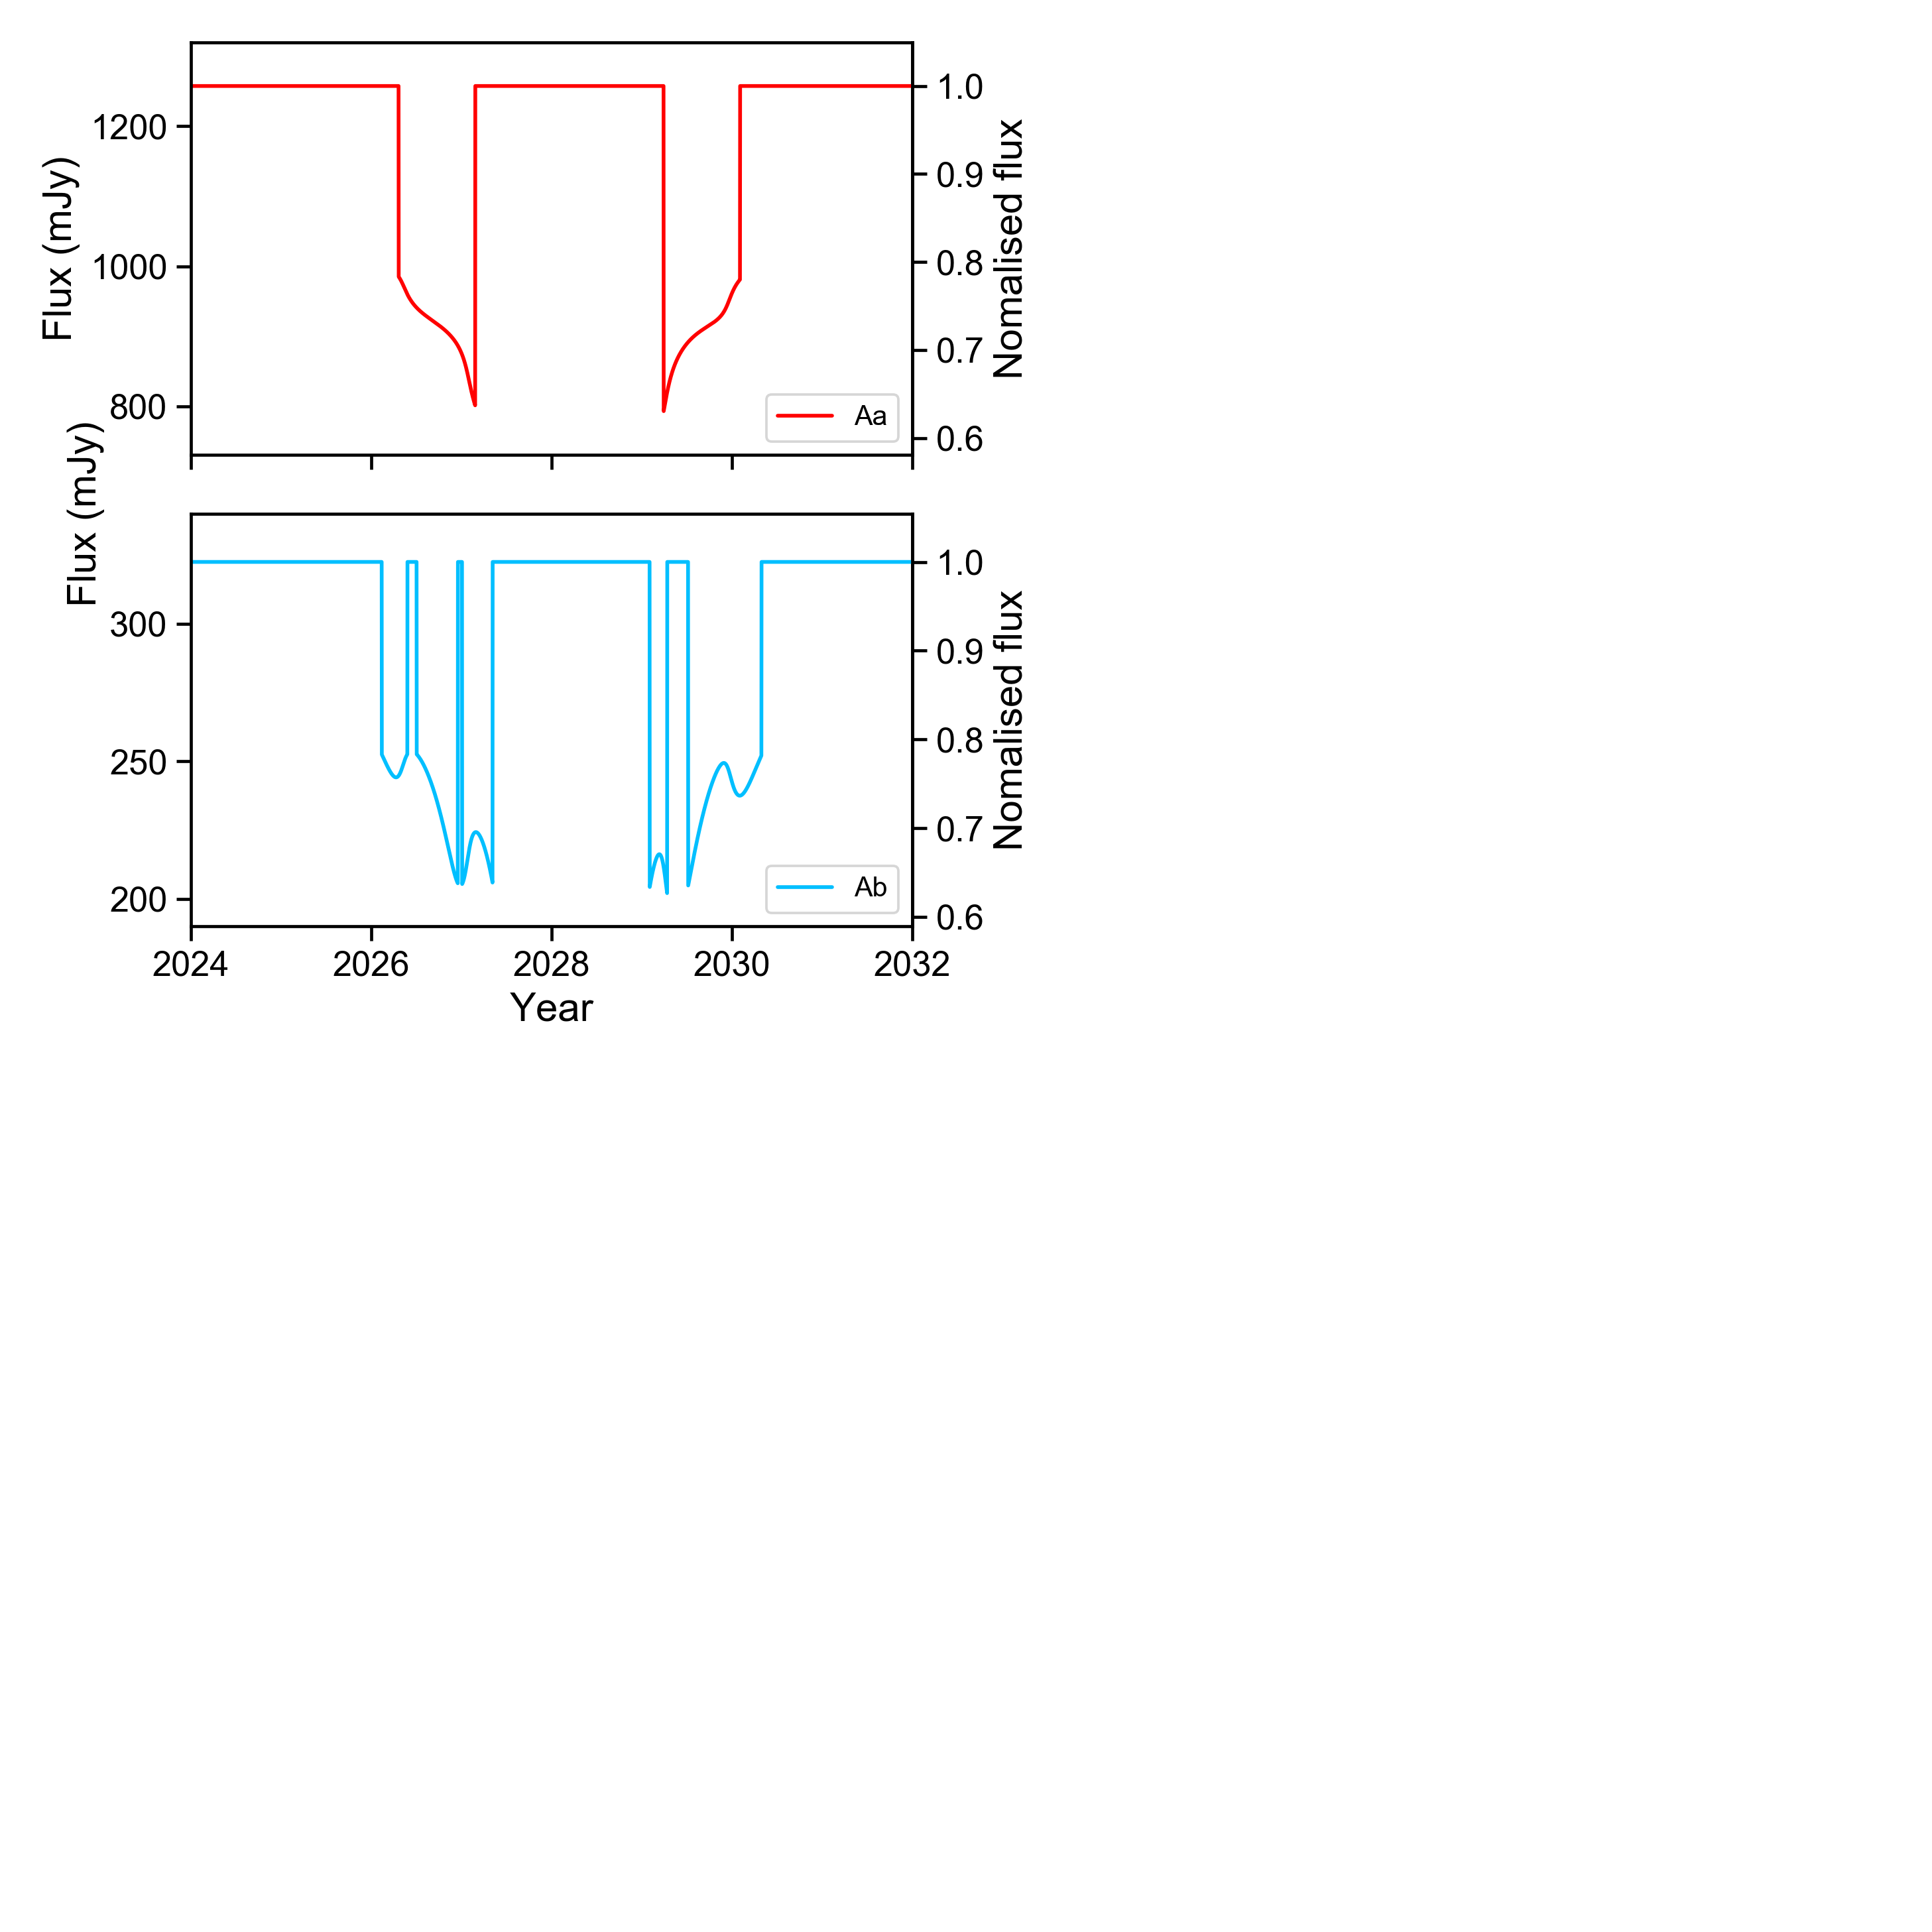

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [53]:
fig, ax = plt.subplots(nrows=2,  figsize=(6,6),sharex=True)
t_yrs = (times/365.25) + 2023
ax[0].plot(t_yrs, flux_Aa, 'red', label = 'Aa')
ax[1].plot(t_yrs, flux_Ab, 'deepskyblue', label = 'Ab')

plt.xlabel("Year")
ax[0].set_ylabel("Flux (mJy)")
ax[1].set_ylabel("Flux (mJy)")
plt.tight_layout()

ax[0].set_xlim(2024,2032)
ax[1].set_xlim(2024,2032)
ax[1].set_xticks([2024,2026,2028,2030,2032])
ax[0].set_ylim(round(fAa_i*0.58, -1), round(fAa_i*1.05, -1))
ax[1].set_ylim(round(fAb_i*0.58, -1), round(fAb_i*1.05, -1))
# ax[0].set_yticks([0.6,0.8,1.0])
# ax[1].set_yticks([0.6,0.8,1.0])
ax[1].yaxis.set_label_coords(-.12, 1)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
leg0 = ax[0].legend(loc='lower right')
leg1 = ax[1].legend(loc='lower right')
# leg0.get_frame().set_facecolor('black')
# leg1.get_frame().set_facecolor('black')

f_norm_Aa = lambda f: f/fAa_i
f_denorm_Aa = lambda f: f*fAa_i
f_norm_Ab = lambda f: f/fAb_i
f_denorm_Ab = lambda f: f*fAb_i

secax0 = ax[0].secondary_yaxis(location='right', functions=(f_norm_Aa, f_denorm_Aa))
secax0.set_ylabel('Nomalised flux')
secax0.set_yticks(np.arange(0.5,1.1,0.1))
secax1 = ax[1].secondary_yaxis(location='right', functions=(f_norm_Ab, f_denorm_Ab))
secax1.set_ylabel('Nomalised flux')
secax0.tick_params(axis='both', which='major', labelsize=14)
secax1.tick_params(axis='both', which='major', labelsize=14)
# fig.align_ylabels(ax[1])
fig.tight_layout()

ax.plot(t_yrs, flux_Aa, 'red', label = 'Aa')
ax.plot(t_yrs, flux_Ab,  'deepskyblue', label = 'Ab')
ax.plot(t_yrs, flux_Ab+flux_Aa, 'darkviolet', label = 'AaAb')

# ax.set_xlabel("Year")
ax.set_ylabel("Flux (mJy)")
ax.set_xlim(2024,2032)
ax.set_xticks([2024,2026,2028,2030,2032])
ax.set_ylim(0,)
# fig.tight_layout()

leg = plt.legend(loc='right', bbox_to_anchor=(1, 0.35), prop={'size': 14})
frame = leg.get_frame()
frame.set_facecolor('white')
ax.tick_params(axis='both', which='major', labelsize=14)

f_norm_A = lambda f: f/(fAa_i+fAb_i)
f_denorm_A = lambda f: f*(fAa_i+fAb_i)

plt.setp( ax.get_xticklabels(), visible=False)

secax0 = ax.secondary_yaxis(location='right', functions=(f_norm_A, f_denorm_A))
secax0.tick_params(axis='both', which='major', labelsize=14)
secax0.set_ylabel('Nomalised flux')
fig.tight_layout()
labelx = -0.15  # axes coords

for j in range(2):
    ax[j].yaxis.set_label_coords(labelx, 0.5)
fig.savefig('REBOUND_LC2.png')



